In [1]:
# %load /Users/f7b/sys/altair/sfmono.py
import pandas as pd
import numpy as np
import altair as alt
# default view: 400 x 300

def sfmono():
    font = "SF Mono"
    
    return {
        "config" : {
             "title": {
                 'font': font, 
                 'fontSize': 14
             },
             "axis": {
                  "titleFont": font,
                  "titleFontSize": 14,
                  "labelFont": font,
                  "labelFontSize": 12
             },
            "view": {
                'width': 500, 
                'height': 400
            },
            "legend": {
                "titleFont": font,      
                "titleFontSize": 12,
                "labelFont": font,
                "labelFontSize": 11
            },
            "text": {
                "font": font,
                "fontSize": 12,
            },
            "header": {
                "titleFont": font,
                "titleFontSize": 11,
                "labelFont": font,
                "labelFontSize": 11
            }
        } # config
    } # return

alt.themes.register('sfmono', sfmono)
alt.themes.enable('sfmono')


<function __main__.sfmono()>

ThemeRegistry.enable('sfmono')

# ESS (Single Node)

In [2]:
ess = pd.read_csv("ESS.csv", skipinitialspace=True)
ess


,IO_Pattern,IO_Mode,Bandwidth
0,Random,Read,23.988
1,Random,Write,30.628
2,Sequential,Read,38.000
3,Sequential,Write,33.785


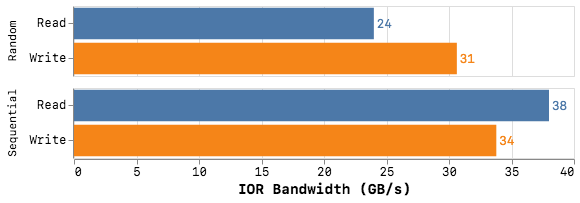

In [94]:
df1_bars = alt.Chart(height=70).mark_bar().encode(
    # limit ticks to make room
    alt.X('Bandwidth:Q', axis=alt.Axis(title="IOR Bandwidth (GB/s)", tickCount=10)),
    alt.Y('IO_Mode:O', title=None),
    color = alt.Color('IO_Mode:N', legend=None)
)

df1_texts = df1_bars.mark_text(
    align="left",
    baseline="middle",
    dx=3
).encode(
    text=alt.Text("Bandwidth", format=".0f")
)

alt.layer(df1_bars, df1_texts, data=ess).facet(row=alt.Row('IO_Pattern:O', title=None))
    

# Core Isolation (Write B/W Coparison)

In [2]:
df2 = pd.read_csv("Core_Isolation_IOR_Write.csv")

# skipping CPU4, CPU8 
df2_melt = pd.melt(df2, id_vars=['Ranks'], 
                   value_vars=['No_CI', 'CI_CPU2', 'CI_CPU4', 'CI_CPU8','CI_CPU12'])

df2_melt['value']= df2_melt['value']/1000
df2_melt

,Ranks,variable,value
0,1,No_CI,7.245
1,2,No_CI,9.854
2,4,No_CI,12.512
3,8,No_CI,14.716
4,16,No_CI,14.864
5,1,CI_CPU2,5.207
6,2,CI_CPU2,7.042
7,4,CI_CPU2,7.996
8,8,CI_CPU2,8.032
9,16,CI_CPU2,8.059


## Graph w/o text on the bar

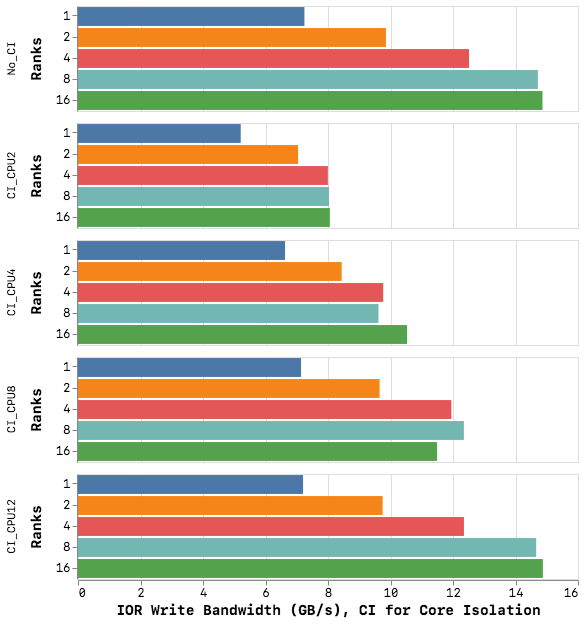

In [4]:

chart = alt.Chart(df2_melt).mark_bar().encode(
    alt.X('value:Q', axis=alt.Axis(title="IOR Write Bandwidth (GB/s), CI for Core Isolation",
                                  tickCount=10)),
    y='Ranks:O',
    color = alt.Color('Ranks:N', legend=None),
    row = alt.Row('variable:N', title="", 
                  sort=["No_CI", "CI_CPU2", "CI_CPU4", "CI_CPU8", "CI_CPU12"])
)
chart

## Graph with text on the bar

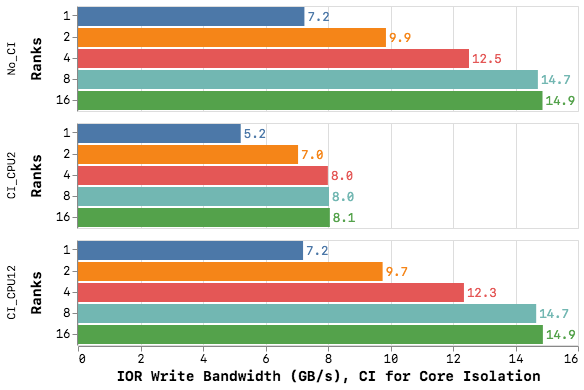

In [10]:
df2_bars = alt.Chart().mark_bar().encode(
    alt.X('value:Q', axis=alt.Axis(title="IOR Write Bandwidth (GB/s), CI for Core Isolation",
                                  tickCount=10)),
    y='Ranks:O',
    color = alt.Color('Ranks:N', legend=None),
)
df2_texts = df2_bars.mark_text(
    align="left",
    baseline="middle",
    dx=3
).encode(
    text=alt.Text("value:Q", format=".1f")
)

alt.layer(df2_bars, df2_texts, data=df2_melt).facet(
    row=alt.Row('variable:N', title="", sort=["No_CI", "CI_CPU2", "CI_CPU12"]))


# NAMD CI Comparison

First, we grap relevant information

  grep "Benchmark time" namd_gpfs_deamons_isolated.txt > NAMD_CI_timing.txt
  grep "Benchmark time" namd_gpfs_deamons_not_isolated.txt > NAMD_Not_CI_timing.txt

Next, we cut only data we are interested:

 awk '{print $6 "," $10}'  NAMD_CI_timing.txt > NAMD_CI_timing.csv
 awk '{print $6 "," $10}'  NAMD_Not_CI_timing.txt  > NAMD_Not_CI_timing.csv
 
Then we manually add column names

That dataframe from this dataset is `df3_`.




In [19]:
df_no_ci = pd.read_csv("NAMD_Not_CI_timing.csv", skipinitialspace=True)


# we look at the following data's distribution
# get its mean and std and regenerate 12 points data to match it
# the goal is to be able to merge with df_no_ci and do comparison

# df_ci = pd.read_csv("NAMD_CI_timing.csv", skipinitialspace=True)

df_ci = pd.Series(np.random.normal(loc=0.009408, scale=0.000014, size=12))
df_concat = pd.concat([df_no_ci['Per_Step'], df_ci], axis=1)
df_concat = df_concat.rename(columns={"Per_Step": "without_CI", 0:"with_CI"})
df_concat['step'] = [i for i in range(12)]

df3_melt = pd.melt(df_concat, id_vars=['step'], value_vars=['without_CI', 'with_CI'])
df3_melt

,step,variable,value
0,0,without_CI,0.013945
1,1,without_CI,0.013258
2,2,without_CI,0.015234
3,3,without_CI,0.015763
4,4,without_CI,0.012519
5,5,without_CI,0.013377
6,6,without_CI,0.021153
7,7,without_CI,0.018253
8,8,without_CI,0.019528
9,9,without_CI,0.017010


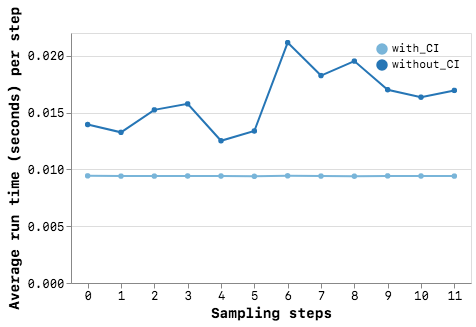

In [37]:
ci_chart = alt.Chart(df3_melt).mark_line(point=True).encode(
    alt.X('step:N', axis=alt.Axis(title="Sampling steps",
                                 labelAngle=0)),
    alt.Y('value:Q', axis=alt.Axis(title="Average run time (seconds) per step", 
                                  tickCount=6, labelAngle=0)),
    color=alt.Color('variable:O', 
                    legend=alt.Legend(title="", orient="top-right", offset=10))
).properties(height=250, width=400)
ci_chart

# Single Client Scaling

In [2]:
df = pd.read_csv("single-client.csv")
df_fpp = df[df.pattern == "fpp"].drop(["pattern"], axis=1) # drop columns
df_fpp

,np,mode,bandwidth
0,1,write,8702.76
1,1,read,6632.26
2,2,write,11678.52
3,2,read,11399.07
4,4,write,13543.61
5,4,read,12548.52
6,6,write,13328.32
7,6,read,13333.78
8,8,write,13934.00
9,8,read,14504.04


In [31]:
(14784-13683)/14784.0

0.07447240259740259

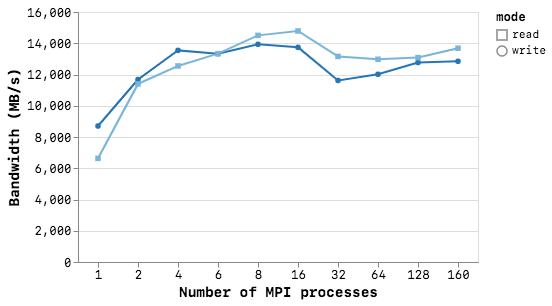

In [29]:
alt.Chart(df_fpp).mark_line(point=True, size=100).encode(
    alt.X('np:N', axis=alt.Axis(title="Number of MPI processes",
                                 labelAngle=0)),
    alt.Y('bandwidth:Q', axis=alt.Axis(title="Bandwidth (MB/s)", tickCount=6, labelAngle=0)),
    color=alt.Color('mode:O',legend=None),
    shape=alt.Shape('mode', scale=alt.Scale(range=['square', 'circle']))
).properties(height=250, width=400)